In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functions as f # My functions
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Context

In this notebook, I analyze a **correlation matrix of asset returns** to identify groups of **correlated** and **uncorrelated** assets through clustering. The goal is to uncover meaningful structure beyond what is visible from raw correlations alone.

I proceed in the following steps:

### 1. Transform Correlation into a Distance Metric

To apply clustering, I convert the correlation matrix $\rho_{i,j}$ into a distance metric using:

$$
X_{i,j} = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}
$$

This transformation ensures that:
- Distances are non-negative and symmetric,
- Similarities become comparable as distances,
- The correlation matrix implicitly standardizes the variables, so no further normalization is needed.

I use a denoised and detoned version of the correlation matrix to remove noise and eliminate the influence of overall market drift. This allows for capturing more meaningful and non-random dependencies.

### 2. Determine the Number of Clusters

Instead of using the elbow method, I adopt a more data-driven approach inspired by *Andriy Burkov*:

- I split the dataset into a training set and a test set.
- I fit a clustering model on the training set and use it to predict cluster assignments on the test set.
- I then independently cluster the test set itself.
- I compare the cluster assignments obtained from both approaches.

The more appropriate the number of clusters, the higher the agreement in cluster assignments between both methods.

### 3. Select the Best Clustering Using Modified Silhouette Scores

Once the number of clusters is chosen, I rerun the clustering multiple times and select the result with the best silhouette quality, as described by *de Prado*:

For a given data point $i$, the silhouette coefficient $S_i$ is defined as:

$$
S_i = \frac{b_i - a_i}{\max(a_i, b_i)}, \quad i = 1, \dots, N
$$

Where:
- $a_i$ is the average distance to other points in the same cluster,
- $b_i$ is the average distance to the nearest different cluster.

To evaluate clustering quality, I compute:

$$
q = \frac{\mathbb{E}(S_i)}{\operatorname{Var}(S_i)}
$$

This ensures not only that clusters are internally tight, but also that they are well-separated from each other.

### 4. Visualize the Final Clustered Correlation Matrix

Finally, I plot the clustered and reordered correlation matrix. This visualization reveals the identified structure and serves as a tool for further interpretation and analysis.

# Step 1

Transforming the correlation matrix into a distance matrix.

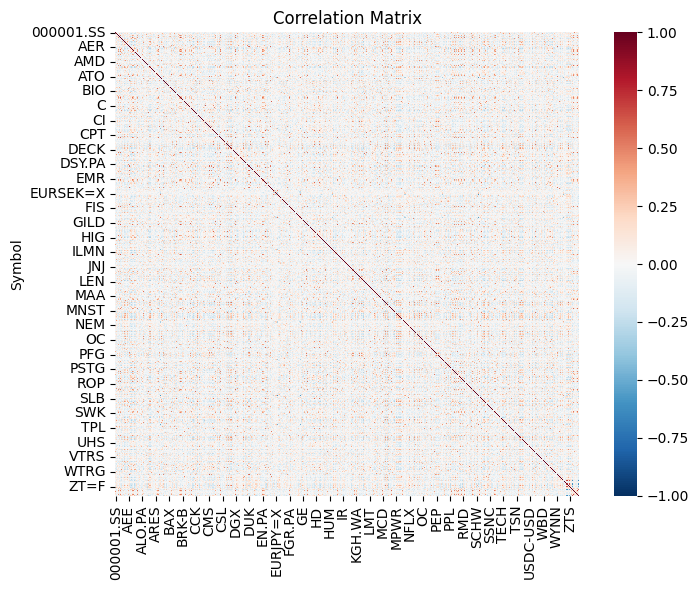

In [2]:
# Using the denoised and detoned corr matrix from sec. 2
corr_matrix = pd.read_csv('denoised_and_detoned_corr_matrix.csv', index_col=0)
corr_matrix = corr_matrix.clip(-1, 1)
corr_matrix.head()

def plot_corr_matrix(corr_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_matrix,
        cmap="RdBu_r",       
        vmin=-1, 
        vmax=1,     
        center=0,
        annot=False,
        square=True
    )
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_corr_matrix(corr_matrix)

dist_matrix = np.sqrt(0.5*(1 - corr_matrix))

# Step 2

I choose to use five clusters, as this configuration provides a meaningful level of granularity and demonstrates the best predictive consistency beyond just two clusters. The clustering evaluation function used for this decision is defined in the file *functions.py*.

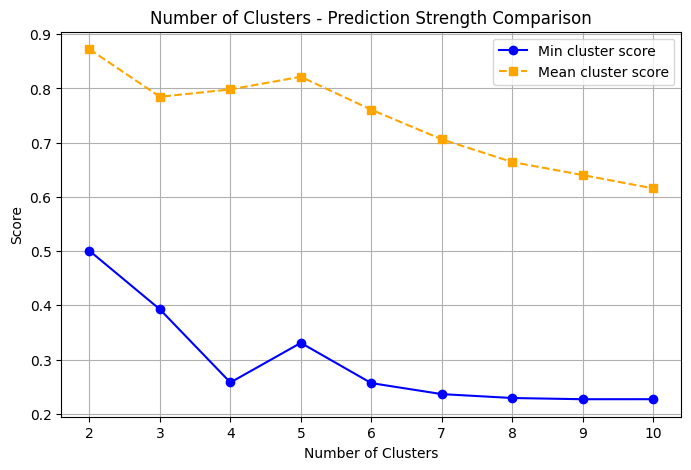

In [3]:
clusters_stats = f.clustering_predictions_strength(dist_matrix, max_n_clusters = 10, test_size=0.5, plot=True)

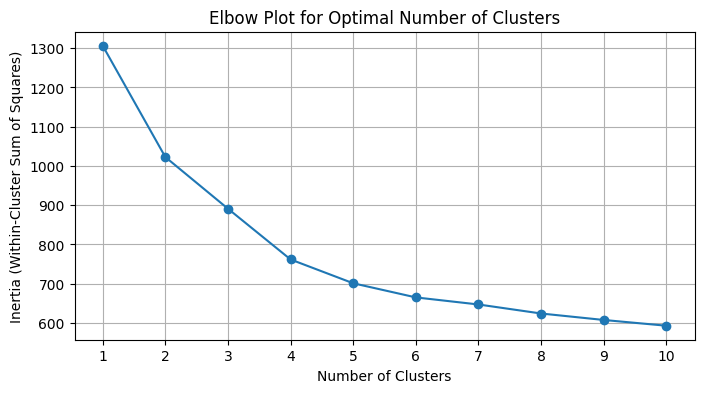

In [4]:
# Elbow plot for comparison

inertia = []

range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dist_matrix)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# Step 3

I determine the optimal clustering by maximizing the silhouette score, which ensures that clusters are not only internally cohesive but also well-separated from one another.

In [5]:
best_model = None
best_score = -1
n_clusters = 5

for i in range(100):
    model = KMeans(n_clusters = n_clusters)
    labels = model.fit_predict(dist_matrix)
    silh_samples = silhouette_samples(dist_matrix, labels)
    score = np.mean(silh_samples) / np.std(silh_samples) # Score from le Prado's book

    if score > best_score:
        best_score = score
        best_model = model

best_model.fit(dist_matrix)
labels = best_model.labels_

# Step 4

Plotting the clustered matrix. I additionally sort the matrix by correlations within each cluster, to further improve interpretability.

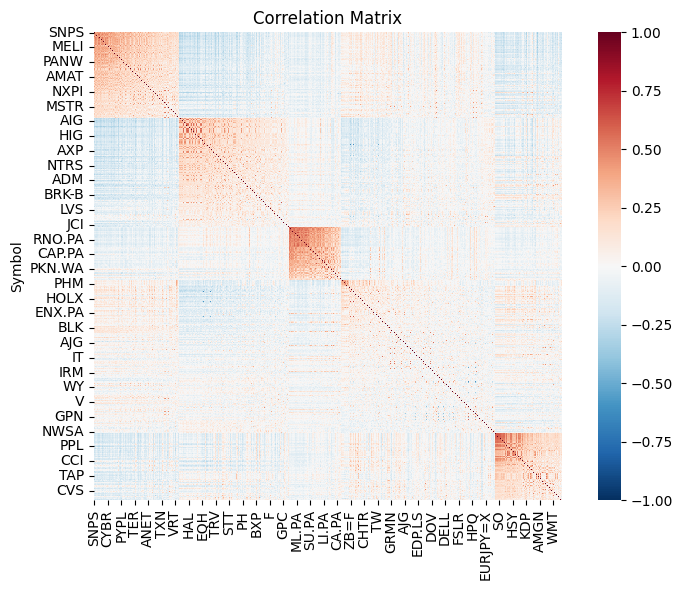

In [6]:
# A DataFrame to store labels and average correlation
corr_mean = []
for cluster in np.unique(labels):
    cluster_indices = np.where(labels == cluster)[0]
    sub_corr = corr_matrix.iloc[cluster_indices, cluster_indices]

    # In each cluster order the values by mean correlation within the cluster
    means = sub_corr.mean(axis=1)
    for idx, mean_val in zip(cluster_indices, means):
        corr_mean.append((idx, cluster, mean_val))

# Sorting the dataframe
corr_df = pd.DataFrame(corr_mean, columns=["idx", "cluster", "mean_corr"])
sorted_indices = corr_df.sort_values(["cluster", "mean_corr"], ascending=[True, False])["idx"].to_numpy()

# Reordering and plotting the correlation matrix
sorted_corr = corr_matrix.iloc[sorted_indices, sorted_indices]
plot_corr_matrix(sorted_corr)